# CS110 Final Project

Leo Ware  
December 18, 2020

Project created and designed in collaboration with Andre Vacha. Much of the theoretical work was done together. The code in this document is mine.

### Background
An old problem in statistics is how to estimate the causal effect of a treatment in an observational dataset. In an experimental dataset, where treatment is assigned randomly to units, this is trivially easy. Because treatment is randomly assigned, the researcher can assume that the treatment and control groups are drawn from the same distribution. So, they can simply compare the average outcomes for each group---or apply any other model---without having to correct for differences between groups.

However, in observational data, researchers cannot assume that treatment and control groups are drawn from the same distribution. Worse, assignment to treatment or control will often correlate with the unit's predisposition to certain outcomes or to the treatment. If you have heart disease, then you will be more likely to get treated for it and you will try harder to get treated for it than someone who does not.

Matching is a nonparametric method for estimating the causal effect of treatment in observational datasets. It works by going through the treatment units and comparing them to the controls on potential confounders---other variables about which the research possess information. Then, it matches each treatment to the control that most closely matches it on these confounders. Under the assumption that every potential confounder is observed, these matched pairs can then be directly compared to get an estimate of the causal effect of treatment.

**#sampling** I provide an implementation of the matching algorithm, which identifies biases in the sampling of an observational dataset and systematically resamples it to create a new dataset which can be used for causal analysis. This demonstrates deep understanding of the ideas behind sampling: bias mitigation, confounders, and randomness.

### Matching as a computational problem
The problem of matching each treatment to the nearest control can be modeled as a form of nearest neighbor search. For each treatment unit, the search algorithm must search among potential controls to find the nearest comparison, where distance is the euclidean distance between feature vectors representing the two units.

The naive solution to the problem---brute force search---involves iterating over every combination of treatment and control, measuring the distance, and then selecting the nearest control to each treatment. My implementation of this algorithm follows.


In [1]:
class Unit:
    """Class to represent units in the dataset"""
    def __init__(self, id, values):
        self.id = id
        self.values = values
    
    def __repr__(self):
        return f"Unit(id={self.id}, values={self.values})"
    
    def __eq__(self, unit):
        """Magic method to test unit equivalence--makes '==' work between units"""
        try:
            return self.values == unit.values
        except AttributeError:
            return False

# tests
foo = Unit(id=0, values=[0])
bar = Unit(id=1, values=[1])
assert foo.id == 0
assert foo.values[0] == 0
assert foo != bar
assert foo == foo

*The above is a class to represent units in the dataset. These would probably correspond to rows in a table---the individuals to whom treatment is applied or not applied. I used a class here because I wanted to associate data with an id for each, and I thought accessing these via attributes would be less error prone that, say, sorting them in tuples and using indeces.*

**#professionalism** Throughout this assignment, I follow pep8 with regard to capitaliztion and spacing conventions. I provide helpful and concise docstrings for almost every function and method following the official Google docstring format.

In [2]:
def distance(unit1: Unit, unit2: Unit) -> int:
    """Euclidean distance between two nodes"""
    return sum((i - j)**2 for i, j in zip(unit1.values, unit2.values))**0.5

# tests
foo = Unit(id=0, values=[0])
bar = Unit(id=1, values=[1])
assert distance(foo, foo) == 0
assert distance(foo, bar) == 1

*The above calculates the distance between two Units. It is a useful helpful function that will recurr throughout the code.*

In [3]:
def matching_brute_force(treatments, controls) -> dict:
    """Brute force solution to the matching problem
    
    Args:
        treatments: a list of Unit s, the member of the treatment group
        controls: a list of Unit s, the member of the control group
    
    Returns:
        a dictionary mapping treatment ids to control ids
    """
    matches = {}
    
    for treat in treatments:
        
        # sentinel values track the best found match
        best_match = None
        best_match_distance = float('inf') # because no match is the worst possible outcome
        
        # we have to check each control individually
        for control in controls:
            dist = distance(control, treat)
            
            # if it's the best yet, remember it
            if dist < best_match_distance:
                best_match_distance = dist
                best_match = control
        
        matches[treat.id] = best_match.id
        
    return matches

# tests
controls = [Unit(id=i, values=[i]) for i in [1, 2, 3]]
treats = [Unit(id=i, values=[j]) for i, j in zip([4, 5, 6], [-1, 2.1, 3])]
assert matching_brute_force(treats, controls) == {4: 1, 5: 2, 6: 3}

*This is the brute force implementation of matching. It works--as described above--by iterating over each treatment, and iterating over each control to find the best match for each.*

The compute time of measuring distance is $\Theta(d)$ in the number of features. Because of the nested for-loop, we can see that the whole algorithm will require compute time proportional to $\Theta(dtc)$ where d is the number of features, t is the number of treatment units, and c is the number of control units. We can assume that, for most real-world datasets, the ratio between the number of treatment and control units is bounded by some constant. So, this formula becomes $\Theta(dn^2)$ where n is the total number of units in the study.

Note that this is the Big-Theta of compute-time. Since there is no early stopping, this algorithm will always require at least $\Theta(dn^2)$ time, even if it finds the best match on the first comparison. We will see that, although the worst case bound is difficult to improve upon, it is possible to make the algorithm significantly faster in practice by cutting away at the best-case.

### The KD-Tree algorithm
My solution to the search problem was to use a data structure called the KD-Tree. It belongs to a class of algorithms called *metric trees*, which are search trees which try to respect the underlying spatial structure of the data to make multivariate search easier. The KD-Tree works by envisioning each study unit as a no more or less than the vectorization of its features---a point in the space of all possible units. Then, it constructs a binary search tree where each branch is a partition of the space of features into two parts.

In [4]:
# I have some functions set to type check inputs when this is True. This makes it easier to catch some bugs.
ENFORCE_TYPES = False

In [9]:
class Node(Unit):
    """A class to represent nodes in the KD-Tree"""
    
    def __init__(self, id, values, axis=None):
        super().__init__(id, values)
        self.parent = None
        self.right = None
        self.left = None
        self.axis = axis
    
    def __repr__(self):
        return f"Node(id={self.id}, values={self.values}, axis={self.axis})"
    
    def dist_to_boundary(self, node: "Node") -> float:
        """The signed distance from node to the decision boundary defined by self"""
        return float(self.values[self.axis] - node.values[self.axis])
    
    def decision(self, node: "Node") -> bool:
        """Whether to place a node in the left subtree"""
        return self.dist_to_boundary(node) <= 0
    
    def opposite(self, node: "Node") -> "Node":
        """Returns self.right for self.left and vice versa"""
        if node == self.left:
            return self.right
        else:
            return self.left
    
    def get_tree(self, prefix: str = "") -> None:
        """Print representation of the subtree based at self"""
        print(prefix + self.__repr__())
        if self.left:
            self.left.get_tree(prefix + '\t')
        if self.right:
            self.right.get_tree(prefix + '\t')

# tests
foo = Node(id=0, values=[0], axis=0)
bar = Node(id=1, values=[1])
foo.left = bar

assert foo.dist_to_boundary(bar) == -1
assert foo.decision(bar)
assert not foo == bar
assert foo.opposite(None) == bar
assert foo.opposite(bar) == None

*This class will represent individual units in the KD-Tree. Since it is still handling units from the dataset, I created it as an instance of the Unit class so that it can inherit all of Unit's functionality. In a KD-Tree, each node represents a partition of the feature space in addition to a piece of data. So, it extends this functionality with .decision() and .dist_to_boundary() which are for reasoning about this partition. It also has attributes for representing part-child relationships in the tree.*

In [10]:
class Tree:
    """Class to represent the KD-Tree
    
    Attributes:
        item_len: the length of node.values for all nodes in the treee
        root: The Node at the root of the tree
    """
    
    def __init__(self, ids: list = None, values: list = None, nodes: list = None):
        # arg parsing
        if not sum(((ids is not None and values is not None), nodes is not None)) == 1:
            raise ValueError("Please specify either ids and values, or nodes")
        if values:
            self.item_len = len(values[0])
            nodes = [Node(id, value) for id, value in zip(ids, values)]
        elif nodes:
            self.item_len = len(nodes[0].values)
        
        # set up the structure of the tree
        self.root = self.build(nodes, 0)
        self.set_parents()
    
    def get_tree(self) -> None:
        """Prints visual representation of the tree"""
        self.root.get_tree()
    
    def get_next_axis(self, axis: int, nodes: list) -> int:
        """Takes the parent's axis and the set of nodes to partition and determines which axis to split on"""
        # this algorithm iterates through axes at each level
        # an alternative would be to pick the one with maximum variance to get the best split
        # calculating variance along each axis is expensive though
        return (axis + 1) % self.item_len
    
    def axis_median(self, nodes, axis):
        """Finds the median node in a list along the given axis of comparison"""
        if len(nodes) == 0:
            return
        
        # Sorts the nodes and returns the one in the middle, which is O(nlogn)
        # The fastest median algorithms are O(n), but I thought the 2-5x speedup here
        # was unlikely to be worth the cost in maintainability. I would upgrade if 
        # this became a bottleneck.
        nodes.sort(key=lambda n: n.values[axis])
        return nodes[len(nodes)//2]
    
    def build(self, nodes, axis):
        """Recursively builds the tree"""
        # find pivot
        pivot = self.axis_median(nodes, axis)
        pivot.axis = axis

        # partition nodes using Node's .decision() method
        larger = []
        smaller = []
        for node in nodes:
            if node.id == pivot.id:
                pass
            elif pivot.decision(node):
                larger.append(node)
            else:
                smaller.append(node)

        # recursive calls to construct subtrees
        if larger:
            # left = larger
            pivot.left = self.build(larger, self.get_next_axis(axis, larger))
        if smaller:
            pivot.right = self.build(smaller, self.get_next_axis(axis, smaller))

        return pivot
    
    def set_parents(self):
        """Sets up parent attributes on each node in a built tree using depth first traversal"""
        stack = [self.root] # stack for depth first traversal
        while stack:
            node = stack.pop()
            
            # if children exist, tell them their parents and push them to the stack
            if node.left:
                node.left.parent = node
                stack.append(node.left)
            if node.right:
                node.right.parent = node
                stack.append(node.right)

# tests
ids = [0, 1, 2]
values = [[i] for i in ids]
foo = Tree(ids=ids, values=values)
assert foo.root.id == 1
assert foo.root.left.id == 2
assert foo.root.right.parent == foo.root

*The Tree class represents the complete KD-Tree and presents a user friendly interface to the more complicated underlying methods. The most important method here is .build() which constructs the tree. This relies on the axis manipulation methods .get_next_axis() and and .axis_median().*

##### .build()
On a technical level, the tree constructs levels one at a time using the .build() method. Each level has an axis of comparison, which is the feature variable that is being compared at that level; it rotates through feature variables in its choice of axis of comparison at each level.

At each level, it finds a pivot---the datapoint with the median (or a related) value along the axis of comparison and sets this as the root of the subtree. Then, it divides data points into those larger and smaller than the pivot along the axis of comparison. Those larger are grouped into *larger*, those smaller into *smaller*. .build() is called recursively to construct left and right subtrees out of *larger* and *smaller* respectively.

This is a recursive function. So, it has to have a base case. Here, the base case is when either *larger* or *smaller* is empty after the partition. Then, the function does not construct a subtree but leaves the parent Nodes child pointer null.

#### search()

The real action of the KD-Tree is in the search. This is quite a complicated process, so I have broken it up into several functions that I will explain individually. The general idea is that search starts with a new query and navigates from the top to the bottom using the .decision() methods on each node. This will put it next to a leaf node, which, although not necessarily the closest, is a fair approximation.

Then, it navigates back up the tree, examining larger and larger subtrees. It uses clever pruning logic to avoid looking at subtrees which could not possibly find the answer, making it significantly faster in practice than brute force search.

In [11]:
class search_result:
    """Nice class to package search results"""
    def __init__(self, node, distance):
        if ENFORCE_TYPES:
            distance = float(distance)
            if not (isinstance(node, Node)):
                raise TypeError("node must be a Node, distance a float")
            
        self.node = node
        self.distance = distance
    
    def __repr__(self):
        return f"search_result(node={self.node}, distance={self.distance})"

# tests
ENFORCE_TYPES, old = False, ENFORCE_TYPES # suspend type checking
assert search_result("foo", 1).distance == 1
assert search_result("foo", 1).node == "foo"
ENFORCE_TYPES = old # restore

*This is a lightweight wrapper class to store the results of the search functions below. Again, I used this as opposed to a tuple or other way of storing the data because I thought that access the data via attribute notation would be less error prone.*

In [12]:
def search_down(root: Node, query: Node, best: search_result = None) -> search_result:
    """Navigates to the bottom of the tree"""
    
    # debugging stuff
    if ENFORCE_TYPES and not (isinstance(node, Node) and isinstance(query, Node)):
        raise TypeError("node, query must be instances of Node")
        
    node = root
    while True:
        # figure out which subtree would fit better
        pref_search = node.left if node.decision(query) else node.right
        
        # take that node if possible, else the other sibling if it exists
        if pref_search:
            node = pref_search
        elif node.opposite(pref_search):
            node = node.opposite(pref_search)
        
        # if neither exists, begin working back up the tree
        else:
            return search_up(node=node, query=query, root=root, best_match=best)

# kind of hard to test this on it's own

*This function starts at the top of a subtree and navigates to the bottom using the .decision() method on node. This means that the query is moved to the same position that it would be if it were a control being added to the tree. The node in the position it would have occupied becomes our first guess as to the best match.*

In [13]:
def search_up(node: Node, query: Node, root: Node, best_match: search_result = None) -> search_result:
    """Starting at the bottom of the subtree, work upwards in search of the best match"""
    
    # debug stuff
    if ENFORCE_TYPES and not (isinstance(node, Node) and isinstance(query, Node) and isinstance(best, search_result)):
        raise TypeError("query, node must be instances of Node. best must be search_result.")
    
    # get a baseline best match
    node_result = search_result(node=node, distance=distance(node, query))
    if best_match is None or node_result.distance < best_match.distance:
        best_match = node_result
        
    while True:
        
        # are we done?
        if node.id == root.id or not node.parent:
            return best_match
        
        # is the parent better?
        parent_dist = distance(query, node.parent)
        if parent_dist < best_match.distance:
            best_match.node = node.parent
            best_match.distance = parent_dist
            
        # check if we have to search the sibling tree
        same_side_boundary = node.parent.decision(best_match.node) == node.parent.decision(query)
        closer_than_boundary = abs(node.parent.dist_to_boundary(best_match.node)) > best_match.distance
        sibling_tree_exists = node.parent.opposite(node) is not None

        if not (same_side_boundary and closer_than_boundary) and sibling_tree_exists:

            # search the sibling tree
            subtree_search = search_down(root=node.parent.opposite(node), query=query, best=best_match)
            if subtree_search.distance < best_match.distance:
                best_match = subtree_search
        
        node = node.parent

*This function starts at the bottom of a tree and works up it. At each level, it compares its current best match to its parent, updating the best match if it is better. Then, it tries to prove that its sibling tree cannot contain a better match. If it cannot do this, it searches this too, updating the best match if it finds a new best there.*

To find the best match given a leaf node which is a good guess, the search moves up level by level in a form of pruned depth-first-search. Starting with this guess, it moves up the tree, searching for a better match. At each level, it looks at two places which could have new best matches: the parent of the current node and the sibling subtree of the current node. For example, if C is the current node in the diagram below, it will search A and the subtree based at B---the nodes B, D and E.

```
Diagram 1. The subtree based as A

       A
      / \
     B   C
    / \
   D   E

```

Comparing to A is cheap and fast, so it always does this. But, comparing to the entire subtree based at B is potentially quite expensive. So, it will attempt to show that that this isn't necessary. Recall that in the KD-Tree, the branch at each represents a partition of the feature space. The idea here is to think of this partition as an actual plane dividing the feature space. See diagram 2 for an illustration. The point marked x is the root of the subtree. Nodes to the right of the partition go into the right subtree, while the nodes to the left go into the left subtree.

```
Diagram 2. Units partitioned by X

  l       |       r  r
   l      |  
 l l  l   |    a
  l       x  r   b
          |
```

Now note the points labeled a and b. Pretend that a is a query and b is the current best match. Think about what we know. Since a is closer to b than it is to the partition, we know that none of the points on the other side of the partition can be closer than b. So, we do not need to search them.

The search function uses the same kind of reasoning. It asks the parent how far the query is from the parent's partition. Then, if it is farther from this than it is from the current best match, then the search algorithm will "prune" -- i.e., ignore -- the subtree on the other side of the partition.

If it does have to search the subtree, it will use search down to do so. Making these two functions kind of recursive together. This call will then lead to a subordinate search_up() call which will find the best match in the subtree. Note that all search_up calls need access to the current best match if they are going to do the most efficient possible bounding. So, the current best match is passed as a parameter to search_down() and handed off to the subordinate search_up() call.

search_up() will continue in this way until it reaches the root node. This will be the root of the tree in the main search, and it will be the top of the subtree in subordinate searches.


In [14]:
def nearest_neighbor(tree: Tree, query: list) -> search_result:
    """Finds the unit in tree which is closest to query by Euclidean distance"""
    node = query if isinstance(query, Node) else Node(id=None, values=query)
    return search_down(tree.root, node)

# tests
ids = [0, 1, 2]
values = [[i] for i in ids]
foo = Tree(ids, values)

assert nearest_neighbor(foo, [1]).node.id == 1
assert nearest_neighbor(foo, [1.1]).node.id == 1
assert nearest_neighbor(foo, [0]).node.id == 0
assert nearest_neighbor(foo, [-1]).node.id == 0

*User friendly interface function to the more complicated search_down() and search_up() functions.*

### Efficient Matching

All of these pieces come together in the final algorithm, which is an efficient implementation of the matching algorithm. This algorithm works by pushing all the controls from a dataset into a KD-Tree and then using nearest_neighbor() to find the best match for each treatment unit.

In [15]:
def kd_matching(treatment, controls):
    matches = {}
    
    # set up tree and match
    tree = Tree(nodes=controls)
    for treat in treatment:
        matches[treat.id] = nearest_neighbor(tree, treat).node.id
        
    return matches

controls = [Node(id=i, values=[i]) for i in [1, 2, 3]]
treats = [Node(id=i, values=[j]) for i, j in zip([4, 5, 6], [-1, 2.1, 3])]
assert kd_matching(treats, controls) == {4: 1, 5: 2, 6: 3}

### Efficientcy of kd-matching

This was a lot of work for a problem that could be solved in a couple lines in the brute-force matching solution. How much did it help? Well, kd-matching constists of two main calls: the call to build the kd-tree from the controls and the nearest_neighbor() calls for each treatment.

**Building the tree**  
There are $\log(n)$ levels of the tree, and constructing each level takes three steps: finding a pivot, partitioning the nodes, and recursive calls to build the next levels. Finding the pivot is $O(m \log m)$ in the number of nodes in the subtree, since it involves finding the median of the subtree along one of the axes, which in turn means sorting the list of nodes in the subtree in my implementation. Partitioning the nodes is $O(md)$ in the number of nodes in the subtree since the decision to put them in the left or right subtree is a distance calculation, hence $O(d)$ in the number of dimensions. Making the recursive calls is $O(1)$, and although it takes longer to execute them, we will count this against the next levels.

Let's upper bound $m$, the number of nodes in each subtree, with $n$, the number of nodes in the tree. Then, the worst case time to build the tree will grow with,

$$
O (\log(n)(n \log n + nd)) =
O (n \log(n) + nd \log(n)) =
O(nd\log(n))
$$

**Matching the treatment units**  
Matching each treatment unit involes iterating over the treatment units $O(n)$, and for each finding the nearest neighbor. For all of its clever bounding, nearest neighbor search is still $O(dn)$. Even though in the majority of cases, it will be able to prune a significant number of subtrees it will not be able to do this under some circumstances, for example, under high dimensionality. When it can't prune effectively, each treatment must be compared ($O(d)$) to each control ($O(n)$). So, matching the treatment units will be worst case $O(dn^2)$ -- i.e., no asymptotic worst case improvement over brute force search.

This means that the cost of matching the treatment units will blot out any costs related to constructing the tree in the asymptotic worst case. So, the asymptotic worst case for the whole kd_matching() function will be:

$$O(dn^2)$$

### Computational tradeoffs: brute-force and kd matching

The first, critically important, thing to note when comparing these two approaches to matching is that both have the same worst case time complexity -- $O(dn^2)$. So, even if kd-matching may have some nice optimizations that will help under most circumstances, it will still perform quite poorly under some circumstances.

Let's move away from the asymtotic forms though and see how these algorithms perform in practice.

In [16]:
import time
import matplotlib.pyplot as plt

def time_for_dataset(dataset, n0, ni, sims=5):
    bf_times = {}
    kd_times = {}

    for n in range(n0, ni):
        
        # generate data
        tr, co = dataset(n)
        
        # time each function
        t = time.time()
        for _ in range(sims):
            matching_brute_force(tr, co)
        bf_times[n] = (time.time() - t)/sims

        t = time.time()
        for _ in range(sims):
            kd_matching(tr, co)
        kd_times[n] = (time.time() - t)/sims
    
    # create graphics
    plt.plot(list(bf_times.keys()), list(bf_times.values()), label="Brute Force")
    plt.plot(list(kd_times.keys()), list(kd_times.values()), label="KD Matching")
    
    plt.xlabel("Number of Treatment Units")
    plt.ylabel("Avg. Time (s)")
    plt.legend()

*This function takes a data generating function as input and generates a plot of how well each function does on the data generated by this function.*

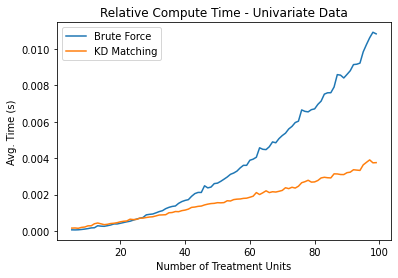

In [17]:
# try for univariate data
def univariate(n):
    treatment = [Node(id=i, values=[i]) for i in range(n)]
    control = [Node(id=i + n, values=[i]) for i in range(n)]
    return treatment, control

plt.title("Relative Compute Time - Univariate Data")
time_for_dataset(univariate, 5, 100)

*This plot shows how matching time grows as a function of input size for each matching function. We can see that for univariate linear data, although kd_matching() plausibly has the same asymptotic complexity, it has much better constant factors. It appears linear here.*

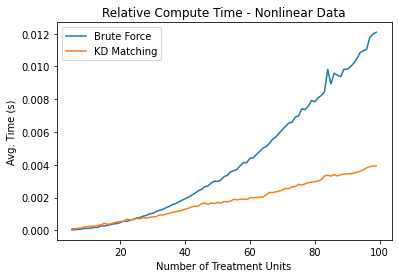

In [18]:
# try for nonlinear data
def nonlinear(n):
    treatment = [Node(id=i, values=[2**i]) for i in range(n)]
    control = [Node(id=i + n, values=[2**i]) for i in range(n)]
    return treatment, control

plt.title("Relative Compute Time - Nonlinear Data")
time_for_dataset(nonlinear, 5, 100)

*The same appears to be true when the variables themselves are not linearly distributed. This plot also shows growth in compute times but for data which is highly nonuniformly distributed.*

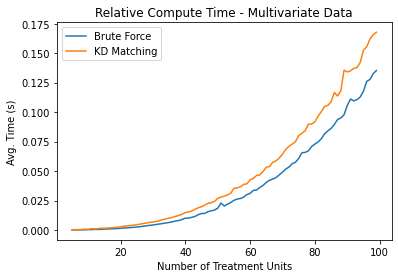

In [19]:
import random

# try for multivariate data
def multivariate(n):
    treatment = [Node(id=i, values=[random.random() for _ in range(n)]) for i in range(n)]
    control = [Node(id=i+n, values=[random.random() for _ in range(n)]) for i in range(n)]
    return treatment, control

plt.title("Relative Compute Time - Multivariate Data")
time_for_dataset(multivariate, 5, 100)

*This is another plot showing compute time as a function of input size. In this test, the input of size n consisted of n n-dimensional arrays of random data. The KD-Tree appears to do significantly worse than the brute force algorithm here.*

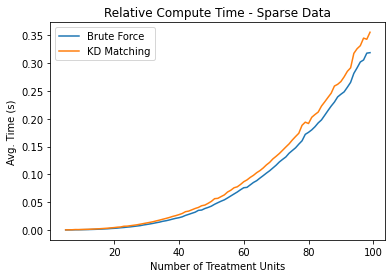

In [20]:
# try for sparse data
from random import shuffle

def sparse_vec(i):
    thing = [0] * i + [1]
    shuffle(thing)
    return thing

def sparse(n):
    treatment = [Node(id=i, values=sparse_vec(n)) for i in range(n)]
    control = [Node(id=i + n, values=sparse_vec(n)) for i in range(n)]
    return treatment, control

plt.title("Relative Compute Time - Sparse Data")
time_for_dataset(sparse, 5, 100)

*This also appears to be a challenge for the kd-matcher. This plot shows growth in compute times as a function of input for each function when the input is very sparse. The input of size n consisted of n n+1-dimensional matrices, which were 0's at every location except one 1, which was at a random place in the list. Note that both algorithms take almost twice as much time as they needed in the graph above, even all matches in the dataset are equivalent.*

The takeaway from these plots is basically the same as from the analytical analysis. The kd-tree is better for many kinds of data, but it will not perform better in some circumstances. Highly multivariate data appears to be an example of where they fail very dramatically. Also, for very small input sizes, the fixed costs of the tree appear appear to make it slightly slower than brute force.

#### Other Considerations

Of course, time is not the only resource that algorithms consume. I has focused on it here as opposed to looking at memory or maintainability concerns because it seems like the most relevant for this problem.
- The kd-tree has memory complexity $O(n)$, while the brute force approach is $O(1)$. In practice though, you would have to store input data for each, and so the real asymptotic memory consumption will be the same.
- Both of these solutions are within a couple-hundred lines of code and took a college sophmore ~12 hours to write. So, I don't think they would pose a serious maintainability concern in production.


#### The Bottom Line

- KD-Matching is better for many applications, but it will fail with high dimensional data. There may also be other kinds of data where it is a bad fit. When it performs badly, it is marginally worse than brute force.
- Brute force is quite slow for all data, but it's worse case is marginally better than for kd-matching.
- My recommendation in a production setting would be to have both algorithms ready. When a new matching problem comes in, I would use Kd-Matching unless the numbers of dimensions is quite large--on the order of the size of the dataset. Then, I would apply brute force matching.

**#computationalcritique** In this section, I go in depth into the relative merits of each approach. I use analytical and empirical evidence to analyze each approach. I justified my focus on the time complexity of each solution. I come to a strong, clear recommendation on when each should be used.